## Importing swe-BERT for initial training

In [1]:
!pip install transformers
!pip install tqdm

import torch
import numpy as np
import math
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, AutoModel
from transformers.modeling_outputs import BaseModelOutputWithPooling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# collab command to install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 28.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [9]:
from torch.utils.data import Dataset


import re
def clean_txt (text):
  text = re.sub("¹", "", text)
  text=re.sub("(\\W)+","  ", text)
  return text


class SNLIDataset(Dataset):

    def __init__(self, filename, max_size=None):
        super().__init__()
        self.xs = []
        self.ys = []
        self.sentence_lengths = np.array([])
        count = 0
        with open(filename, encoding="utf-8") as source:
            for i, line in enumerate(source):
                if i == 0:
                  continue
                # print(line)
                if max_size and i >= max_size:
                    break
                try:
                  sentence, sentiment_value = line.rstrip().split('|') # Delimeter to be chosen
                  count += 1
                except:
                  print( "Error when processing the following data ", [line.rstrip().split('|')])
                # print(sentence)
                self.xs.append(clean_txt(sentence))
                self.ys.append(int(sentiment_value.split("\"")[0])) # make sure negative/neutral/positive is labelled correct
                self.sentence_lengths = np.append(self.sentence_lengths, len(sentence.split(" ")))

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

    def __len__(self):
        return len(self.xs)

class SNLIDataset_shell_class(SNLIDataset):
    def __init__(self, xs, ys, sentence_lengths):
      self.xs = xs
      self.ys = ys
      self.sentence_lengths = sentence_lengths

In [3]:


def divide_dataset_to_train_and_test(SNLIDataset, percentage_to_train):
    random_indices = torch.randperm(len(SNLIDataset.xs))
    num_of_sent_in_train = math.floor(len(SNLIDataset.xs)*(percentage_to_train))
 
    train_dataset_xs = np.array(list(map(SNLIDataset.xs.__getitem__, random_indices[0:num_of_sent_in_train])))
    train_dataset_ys = np.array(list(map(SNLIDataset.ys.__getitem__, random_indices[0:num_of_sent_in_train])))
    train_dataset_sent_lengths = np.array(list(map(SNLIDataset.sentence_lengths.__getitem__, random_indices[0:num_of_sent_in_train])))


    test_dataset_xs = np.array(list(map(SNLIDataset.xs.__getitem__, random_indices[num_of_sent_in_train:])))
    test_dataset_ys = np.array(list(map(SNLIDataset.ys.__getitem__, random_indices[num_of_sent_in_train:])))
    test_dataset_sent_lengths = np.array(list(map(SNLIDataset.sentence_lengths.__getitem__, random_indices[num_of_sent_in_train:])))
  
    train_dataset = SNLIDataset_shell_class(train_dataset_xs, train_dataset_ys, train_dataset_sent_lengths)

    test_dataset = SNLIDataset_shell_class(test_dataset_xs, test_dataset_ys, test_dataset_sent_lengths)
    

    return train_dataset, test_dataset



## Create all datasets

In [10]:
financial_news_train_dataset = SNLIDataset('./Financial Data/cleaned_financial_phrases_train.csv')
financial_news_test_dataset = SNLIDataset('./Financial Data/cleaned_financial_phrases_test.csv')
amazon_review_dataset = SNLIDataset('./amazon-review-data/cleaned_amazon_reviews.csv')
test_dataset = SNLIDataset('./sweOnlyProcData/cleaned_all_news.txt')

# data = financial_news_train_dataset[121]

amazon_review_train_dataset, amazon_review_test_dataset = divide_dataset_to_train_and_test(amazon_review_dataset, 0.9)


print("Financial phrases train dataset length: {:,}".format(len(financial_news_train_dataset)))
print("Financial phrases test dataset length: {:,}".format(len(financial_news_test_dataset)))

print("Amazon reviews train dataset length: {:,}".format(len(amazon_review_train_dataset)))
print("Amazon reviews test dataset length: {:,}".format(len(amazon_review_test_dataset)))

print("Own collected news dataset length: {:,}".format(len(test_dataset)))



Financial phrases train dataset length: 4,551
Financial phrases test dataset length: 506
Amazon reviews train dataset length: 27,000
Amazon reviews test dataset length: 3,000
Own collected news dataset length: 521


In [11]:
print(financial_news_train_dataset.xs[:10]) # Dataseten är på något vis olika formatterad som gör att det blir fel senare när man tränar modellen
print(amazon_review_train_dataset.xs[:10])

['Finska  flygbolaget  Finnair  inleder  de  tillfälliga  uppsägningarna  av  kabinpersonal  i  februari  X  ', 'Motsvarande  ökning  av  aktiekapitalet  totalt  X  X  euro  registrerades  i  det  finska  handelsregistret  den  X  maj  X  ', 'Under  det  tredje  kvartalet  av  räkenskapsåret  X  svängde  Efore  till  en  nettoförlust  på  X  X  EUR  jämfört  med  en  nettovinst  på  X  X  EUR  för  motsvarande  period  X  ', 'ALEXANDRIA  Virginia  X  oktober  Aaron  Moss  från  Hampshire  Storbritannien  har  utvecklat  en  dekorativ  design  för  en  telefon  meddelade  US  Patent  amp  Trademark  Office  ', 'Vaisala  Oyj  Börsmeddelande  X  X  X  klo  X  X  X  X  Årsstämman  i  Vaisala  Oyj  beslutade  den  X  mars  X  att  godkänna  bolagets  årsredovisning  för  X  ', 'Produktens  framkantsvikning  maximerar  vädertålighet  och  möjliggör  en  sömlös  takfinish  ', 'Raute  är  noterat  på  den  nordiska  börsen  i  Helsingfors  ', 'KESKO  FOOD  AB  PRESSMEDDELANDE  X  X  X  KL  X  

## Dataset analysis
Here we analyze the length distribution for each dataset

In [ ]:
import matplotlib.pyplot as plt

def plot_data_length(sentence_lengths, datasetName, resolution=1, xparams=True):
    plot_data_length.total_plots += 1
    plt.figure(plot_data_length.total_plots)
    plt.hist(sentence_lengths, bins=int(np.max(sentence_lengths)*resolution), density=True)
    plt.xlabel(datasetName)
    if not xparams:
      plt.tick_params(bottom=False, labelbottom=False)

plot_data_length.total_plots = 0

plot sentence lengths

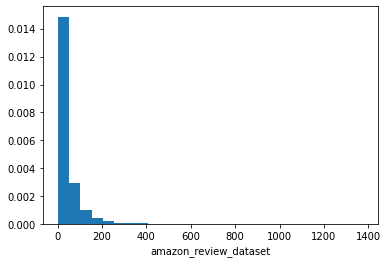

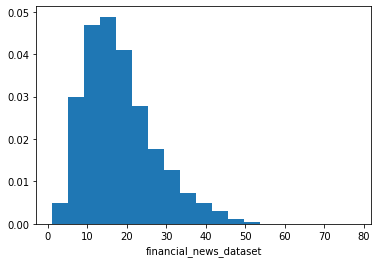

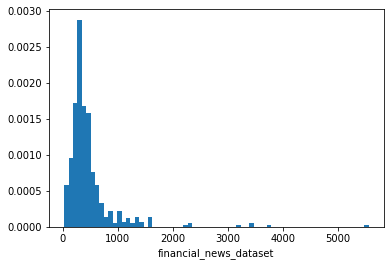

In [ ]:
plot_data_length(amazon_review_dataset.sentence_lengths, "amazon_review_dataset", 1/50)
plot_data_length(np.concatenate([financial_news_test_dataset.sentence_lengths, financial_news_train_dataset.sentence_lengths]), "financial_news_dataset", 1/4)
plot_data_length(test_dataset.sentence_lengths, "financial_news_dataset", 1/80)


# Textfil på formatet data | label | datalängd

# for sentence_length in amazon_reviews.sentence_lengths: 15,17 % av denna. Använd divide_dataset_to_train_and_test
    # hitta rad i textfilen som har datalängd sentence length
        # annars kolla datalängd sentence_length-1 (upprepa tills ngt hittas)
    # ta bort den raden och lägg i separat textfil

# for sentence_length in financial_phrases.sentence_lengths:  #HELA DENNA
    # hitta rad i textfilen som har datalängd sentence length
        # annars kolla datalängd sentence_length-1 (upprepa tills ngt hittas)
    # ta bort den raden och lägg i separat textfil

# for sentence_length in own_collected_news.sentence_lengths: # HELA DENNA 
        # hitta rad i textfilen som har datalängd sentence length
        # annars kolla datalängd sentence_length-1 (upprepa tills ngt hittas)
    # ta bort den raden och lägg i separat textfil

plot label distribution

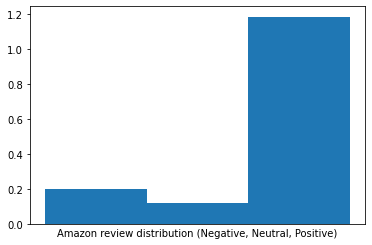

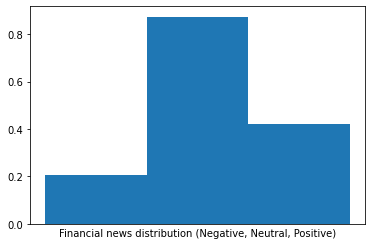

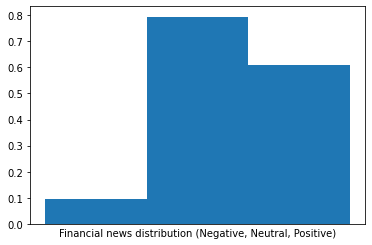

In [ ]:
plot_data_length(amazon_review_dataset.ys, "Amazon review distribution (Negative, Neutral, Positive)", 1.5, xparams=False)
plot_data_length(np.concatenate([financial_news_test_dataset.ys, financial_news_train_dataset.ys]), "Financial news distribution (Negative, Neutral, Positive)", 1.5, xparams=False)
plot_data_length(test_dataset.ys, "Financial news distribution (Negative, Neutral, Positive)", 1.5, xparams=False)

## Import swedish bert

In [12]:
tokenizer = BertTokenizer.from_pretrained('KB/bert-base-swedish-cased', do_lower_case=False)
bert = AutoModel.from_pretrained('KB/bert-base-swedish-cased')

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
tokenized = tokenizer(text=amazon_review_train_dataset[1][0], padding='longest', return_tensors='pt')
print(amazon_review_train_dataset[1][0])
print(tokenized.input_ids)
print(tokenized)

Jag  älskar  den  här  mattan  u  den  är  supersöt  och  sååå  mjuk  Den  är  faktiskt  större  än  jag  trodde  att  den  skulle  vara  Det  är  lätt  att  fälla  ihop  och  lägga  undan  och  det  är  lätt  att  rengöra  Jag  behöver  fler  av  dessa  till  mitt  hus  gt  _  lt  
tensor([[    2,   361,  4766,    97,   382, 21421,    56,    97,    54,  5096,
          7834, 49795,    36,   181, 49811, 49811,  7164,   219,    54,  2644,
           955,   390,   217,  3609,    48,    97,   409,   358,   160,    54,
          1048,    48, 17310,  2034,    36,  3329,  3424,    36,    82,    54,
          1048,    48, 19523, 16880,   361,  1404,  1448,    65,  1021,    76,
          1199,  1004,  2850,  3678,  5175,     3]])
{'input_ids': tensor([[    2,   361,  4766,    97,   382, 21421,    56,    97,    54,  5096,
          7834, 49795,    36,   181, 49811, 49811,  7164,   219,    54,  2644,
           955,   390,   217,  3609,    48,    97,   409,   358,   160,    54,
          1048,  

### Define colate function that tokenizes

In [14]:
def tensor_split(text1, seq_size=200, overlap=50, add_to_start = 2):
  l_total = []
  l_parcial = []
  cls_tokens = torch.unsqueeze(torch.as_tensor([add_to_start]* text1.shape[0]), dim=1)
  if text1.shape[1]//(seq_size-overlap) >0:
    n = text1.shape[1]//(seq_size-overlap)
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      # l_parcial = torch.concat([cls_tokens, text1[:,:seq_size]], dim=1)
      l_parcial = text1[:,:seq_size]
      l_total.append(l_parcial.to(device))
    else:
      # l_parcial = torch.concat([cls_tokens, text1[:,w*(seq_size-overlap):w*(seq_size-overlap) + seq_size]], dim=1)
      l_parcial = text1[:,w*(seq_size-overlap):w*(seq_size-overlap) + seq_size]
      l_total.append(l_parcial.to(device))
  return l_total

In [15]:
def our_collate_fn(data):
    x = [a[0] for a in data]
    y = [a[1] for a in data]
    tokenized = tokenizer(text=x, padding='longest', return_tensors='pt')

    return tokenized['input_ids'], torch.as_tensor(y), tokenized['attention_mask']

In [16]:
from torch.utils.data import DataLoader

def create_training_examples(dataset, batch_size = 64, seq_size = 200, overlap = 50):
    batch_sort_order = np.array_split(dataset.sentence_lengths.argsort()[::-1], round(len(dataset) / batch_size))
    tokenized_train_data = DataLoader(dataset, collate_fn=our_collate_fn, batch_sampler=batch_sort_order) #

    for bindex, (bx, by, ba) in enumerate(tokenized_train_data):
        yield tensor_split(bx, seq_size, overlap), tensor_split(ba, seq_size, overlap, add_to_start=1), by.to(device)
                




In [17]:
import torch.nn as nn

rnn = nn.LSTM(10, 20, batch_first = True)
input = torch.randn(3, 5, 10)
h0 = torch.randn(1, 3, 20)
c0 = torch.randn(1, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

print("Input shape: {}".format([*input.shape]))
print("Output shape: {}".format([*output.shape]))
print("Last hidden state shape: {}".format([*hn.shape]))

Input shape: [3, 5, 10]
Output shape: [3, 5, 20]
Last hidden state shape: [1, 3, 20]


In [68]:
import torch.nn as nn
from sklearn import metrics


class DocBert(nn.Module):
    def __init__(self, bert, hidden_dim=20, num_labels=3):
        super().__init__()
        self.bert =  bert.to(device) # INTE BertForSequenceClassification
        self.lstm = nn.LSTM(bert.config.hidden_size, hidden_dim, batch_first=True).to(device)
        # Input [Batch_size, sequence_length, input_size]
        # Output [1, batch_size, hidden_dim]
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_dim, num_labels).to(device)
    
    def forward(self, x_seqs, a_seqs):
      output = []
      for x_seq, a_seq in zip(x_seqs, a_seqs):
        # print("x_seq, a_seq = {}, {}".format(x_seq, a_seq))
        output.append(self.bert(x_seq, a_seq)[0][:,0,:]) # Only get the embedding of the [CLS]-token [batch_size, number_of_sequences, input_size]
      # print(output)
      _ , (output, _) = self.lstm(torch.stack(output, dim=1)) # [1, batch_size, hidden_dim]
      output = self.relu(output)
      return self.linear(torch.squeeze(output, dim=0))
      #   bertified_seqs.append()
      # self.lstm(, )

    def predict(self, x_seq, a_seq):
      output = self.forward(x_seq, a_seq)
      # print("Output from forward: {}".format(output))
      batch_guess = torch.argmax(output, dim=1)
      return batch_guess

    def get_confusion_matrix(self, sequences, batch_size=8):
      predicted_tensor = torch.as_tensor([])
      correct_tensor = torch.as_tensor([])

      current_correct = 0
      
      current_tried = 0
      for x_seq, a_seq, by in create_training_examples(sequences, batch_size=batch_size):
        prediction = self.predict(x_seq, a_seq).to("cpu")
        # print("Prediction: {} \t Actual {}".format(*prediction, *by) )
        predicted_tensor = torch.concat((predicted_tensor, prediction))
        correct_tensor = torch.concat((correct_tensor, by.to("cpu")))
        # current_correct += torch.sum(prediction==by)
        # current_tried += batch_size
      confusion_matrix = metrics.confusion_matrix(correct_tensor.numpy(), predicted_tensor.numpy())
      


      return confusion_matrix

    def accuracy(self, sequences, batch_size=8):
      current_correct = 0
      
      current_tried = 0
      for x_seq, a_seq, by in create_training_examples(sequences, batch_size=batch_size):
        prediction = self.predict(x_seq, a_seq).to(device)
        # print("Prediction: {} \t Actual {}".format(*prediction, *by) )
        
        current_correct += torch.sum(prediction==by)
        current_tried += batch_size

      return current_correct / current_tried


#### Functions for training and testing a model

In [79]:
import torch.nn.functional as F
def train_docbert(pretrained_bert, dataset, hidden_dim=512, num_labels=3, epochs=1):
  docbert = DocBert(pretrained_bert, hidden_dim, num_labels)
  optimizer = torch.optim.Adam(docbert.parameters(), lr=2e-5) #lr based on docbert article
  for epoch in range(epochs):
    i = 0
    tot_loss = 0
    for x_seqs, a_seqs, by in create_training_examples(dataset, batch_size=8, seq_size=200, overlap=50):
      optimizer.zero_grad()
      preds = docbert.forward(x_seqs, a_seqs)
      loss = F.cross_entropy(preds, by)
      tot_loss += loss
      i += 1
      if i % 200 == 0:
        print(tot_loss / 200)
        tot_loss = 0
      loss.backward()
      optimizer.step()
    
  return docbert


def calc_opt_epoch_docbert(pretrained_bert, dataset, validation_dataset, hidden_dim=512, num_labels=3, max_epochs=50):
  docbert = DocBert(pretrained_bert, hidden_dim, num_labels)
  optimizer = torch.optim.Adam(docbert.parameters(), lr=2e-5) #lr based on docbert article
  last_accuracy = torch.as_tensor(0)
  for epoch in range(max_epochs):
    print("--- EPOCH {} ---".format(epoch))
    
    
    for x_seqs, a_seqs, by in create_training_examples(dataset, batch_size=8, seq_size=200, overlap=50):
      optimizer.zero_grad()
      preds = docbert.forward(x_seqs, a_seqs)
      loss = F.cross_entropy(preds, by)
      
      loss.backward()
      optimizer.step()
    accuracy = docbert.accuracy(validation_dataset, batch_size=1)
    print("current accuracy: {:.2f}".format(100*accuracy))
    # if torch.round(1000*accuracy) <= torch.round(1000*last_accuracy):
    #   return epoch-1
    last_accuracy = accuracy
  return max_epochs



In [44]:
def calc_from_conf_matrix(conf_matrix, label_names):
    col_sums = [0, 0, 0]
    row_sums = []
    tot_sum = 0
    for rindex, row in enumerate(conf_matrix):
        col_sums += row
        row_sums.append(sum(row))
    tot_sum = sum(row_sums)

    accuracy = 0
    for i in range(len(label_names)):
         
        # precision
        precision = conf_matrix[i][i] / col_sums[i]
        print("Precision for {} is {:.2f}%".format(label_names[i], 100*precision))

        # recall
        recall = conf_matrix[i][i] / row_sums[i]
        print("Recall for {} is {:.2f}%".format(label_names[i], 100*recall))

        accuracy += conf_matrix[i][i]
    
    # accuracy
    print("Total accuracy is {:.2f}%".format(100*accuracy/tot_sum))


In [77]:
docbert = train_docbert(bert, financial_news_train_dataset, epochs=30)

KeyboardInterrupt: ignored

In [80]:
golden_epoch_count = calc_opt_epoch_docbert(bert, financial_news_train_dataset, financial_news_test_dataset)
print("best epoch amount: {}".format(golden_epoch_count))

--- EPOCH 0 ---
current accuracy: 86.17
--- EPOCH 1 ---
current accuracy: 85.18
best epoch amount: 0


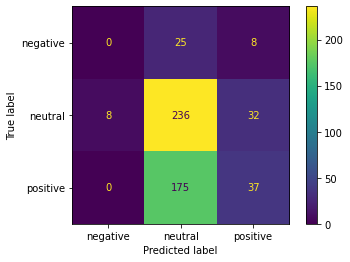

In [53]:
import matplotlib.pyplot as plt


conf_m = docbert.get_confusion_matrix(test_dataset, batch_size=1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_m, display_labels = ["negative", "neutral", "positive"])
cm_display.plot()

In [54]:
print(conf_m)
calc_from_conf_matrix(conf_m, ["Negative", "Neutral", "Positive"])


[[  0  25   8]
 [  8 236  32]
 [  0 175  37]]
Precision for Negative is 0.00%
Recall for Negative is 0.00%
Precision for Neutral is 54.13%
Recall for Neutral is 85.51%
Precision for Positive is 48.05%
Recall for Positive is 17.45%
Total accuracy is 52.40%


# Money calculations
Given that all money is invested at every purchase, this is the percentage gain after buying every stock which the model predicted as positive.

* A true positive news corresponds to a 4.9% increase in stock price.

* A true negative news corresponds to a 5.1% decrease in stock price.

* A true neutral news corresponds to a 0.1% decrease due to brokerage.

In [55]:
def calc_winnings(conf_matrix):
    return 0.949**conf_matrix[0][2] * 0.99**conf_matrix[1][2] * 1.051**conf_matrix[2][2]

In [60]:
winning_factor = calc_winnings(conf_m)
start_capital = 10000

print("By investing {} SEK, we would mulitply our initial investment by {:.3f}, thus having {:.0f} SEK".format(start_capital, winning_factor, start_capital*winning_factor))

By investing 10000 SEK, we would mulitply our initial investment by 3.004, thus having 30044 SEK


## Train and save the financial model

## Load the financial model and evaluate it on similar test-data 
accuracy should be 88%+